In [1]:
using GynC, Plots, Distributions

cookie: C0sIkU76LRl7Hio3
VERSION: 0.5.0


worker_arg: `--worker C0sIkU76LRl7Hio3`



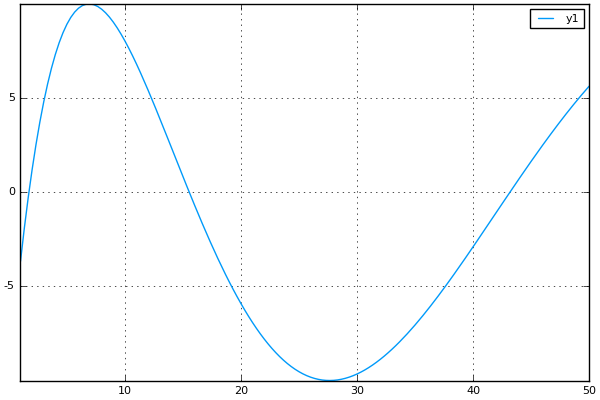

In [14]:
xs = collect(1:1/3:50)
phi(k) = (GynC.Federn.odeohnetreatment(k))[1]
plot(xs, phi.(xs))

In [15]:
measerr = Normal(0,2)
ndata = 300
augz = 100
prior = GynC.Federn.prior

m = GynC.syntheticmodel(xs, phi, prior, ndata, augz, measerr)

augd = 100
@show stdd = KernelDensity.default_bandwidth(m.datas)
ms = GynC.smoothdata(m, augd, stdd)

stdd = KernelDensity.default_bandwidth(m.datas) = 1.7273590948980904


GynC.LikelihoodModel([1.0,1.33333,1.66667,2.0,2.33333,2.66667,3.0,3.33333,3.66667,4.0  …  47.0,47.3333,47.6667,48.0,48.3333,48.6667,49.0,49.3333,49.6667,50.0],[-3.66791,-1.89511,-0.277585,1.19228,2.52192,3.7185,4.78898,5.73997,6.57797,7.30911  …  3.33572,3.60772,3.87575,4.13963,4.39918,4.65423,4.90459,5.15012,5.3907,5.62618],[-0.842423,-5.48473,-1.31728,2.54572,2.62955,1.49114,3.13939,5.11153,4.39878,3.1861  …  4.51142,3.49107,2.56123,4.02198,2.95852,5.13161,3.41155,2.34783,4.45558,7.87852],[-9.53912,-10.0305,-3.57899,-9.69071,-11.0083,-10.5788,-9.24951,0.848489,-5.13837,-2.70278  …  2.40361,-12.6637,-12.6346,-0.507267,6.34059,8.80501,-2.66196,6.64107,-4.21724,-4.59529],Distributions.Normal{Float64}(μ=0.0, σ=2.6426822439951327),Distributions.Normal{Float64}(μ=0.0, σ=2.0))

In [16]:
w0 = ones(length(xs)) / length(xs);
wprior = pdf(prior, xs)
wprior = wprior / sum(wprior);

In [17]:
niter = 500
h = 0.1

ws = Dict()
@time ws["NPMLE"] = GynC.em(m, w0, niter)
@time ws["DS-MLE"] = GynC.em(ms, w0, niter);

INFO: computing likelihood matrix (148x300)


  0.158598 seconds (2.34 k allocations: 1.917 MB)


INFO: computing likelihood matrix (148x30000)


 27.893340 seconds (11.98 k allocations: 115.579 MB, 0.18% gc time)


In [18]:
@time ws["MPLE"]  = GynC.mple(m, w0, niter, .9, h)
@time ws["Reference Prior"] = GynC.mple(m, w0, niter, 1, h);

INFO: computing likelihood matrix (14800x148)
INFO: computing likelihood matrix (300x148)


 11.467140 seconds (603.75 k allocations: 359.102 MB, 4.30% gc time)
 10.662724 seconds (603.02 k allocations: 183.999 MB, 0.44% gc time)



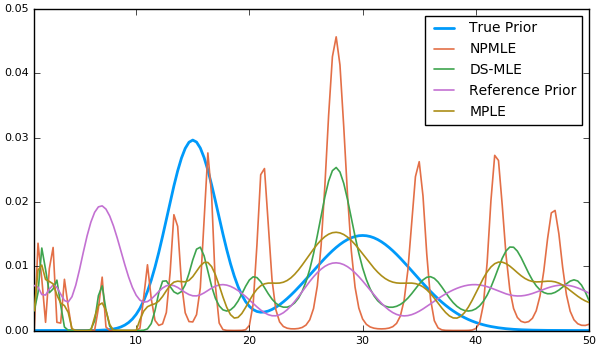

In [19]:
labels = ["NPMLE" "DS-MLE" "Reference Prior" "MPLE"]
densities = map(l->ws[l][end], labels) |> vec

plot(xs, wprior, label="True Prior", linewidth=2, legendfont=font(10), tickfont=font(8), ylims=(0,0.05), size=(600, 350), grid=false)
plot!(xs, densities, labels=labels, linewidth=1.2)

In [10]:
@show sumabs(w0-wprior)
[k=>sumabs(v[end] - wprior) for (k,v) in ws]

sumabs(w0 - wprior) = 0.9402590990987367



Use "Dict(a=>b for (a,b) in c)" instead.


Dict{String,Float64} with 4 entries:
  "MPLE"            => 0.804246
  "Reference Prior" => 1.04659
  "NPMLE"           => 1.2095
  "DS-MLE"          => 1.04278

# Let the treatment begin!

In [21]:
plot(xs, GynC.Federn.maxtreatamplitude)
plot!(xs, map(GynC.Federn.r, xs))

In [140]:
[k=>GynC.Federn.r(v[end]) for (k,v) in ws]


Use "Dict(a=>b for (a,b) in c)" instead.


Dict{String,Float64} with 4 entries:
  "MPLE"            => 0.879343
  "Reference Prior" => 0.963426
  "NPMLE"           => 0.963076
  "DS-MLE"          => 0.922854


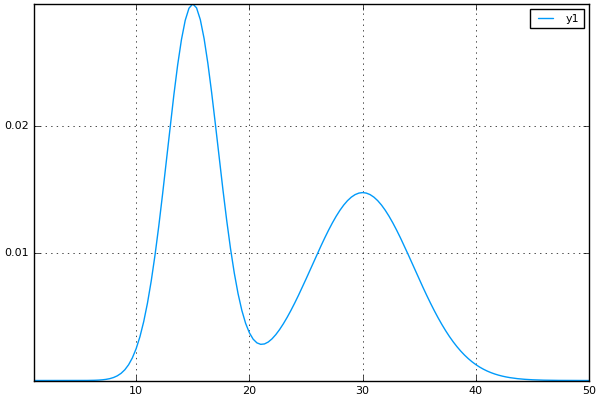

In [139]:
w = wprior
priorplot = plot(xs, w)

In [202]:
function weightedquantile(ys, w; quantiles=collect(1/8:1/8:7/8))
  sp = sortperm(ys)
  cs = cumsum(w[sp])
  mx = cs[end]
  quantileinds = [findfirst(x->x>=q, cs) for q = mx*quantiles]
  ys[sp[quantileinds]]
end

function calcquantiles(ts, sols, w;quantiles = collect(1/10:1/10:9/10))
  res = Matrix(length(ts), length(quantiles))
  for t in 1:length(ts)
      res[t,:] = weightedquantile([sols[x][t] for x in 1:length(xs)], w, quantiles = quantiles)
  end
  res
end

function plotquantiles(ts, sols, w)
    
  res = calcquantiles(ts, sols, w)
  n = size(res,2)
  p = plot()
  mid = Int((n+1)/2)
  offsets = Int((n-1)/2):-1:0 
  for o in offsets
    plot!(ts, res[:,mid-o], fillrange=res[:,mid+o])
  end
  p
end

function bayesposterior(m, data, wprior)
    L = likelihoodmat(m.ys, data, m.measerr)
    GynC.emiteration(wprior, L)
end

bayesposterior (generic function with 1 method)


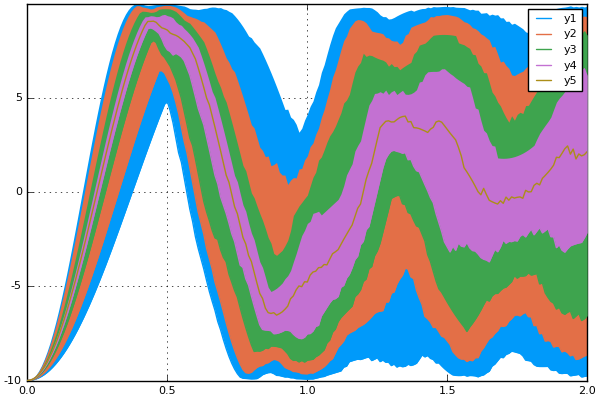

In [203]:
ts = 0:1/100:2
sols = [GynC.Federn.odesol(k,ts) for k = xs]
plotquantiles(ts, sols, w)


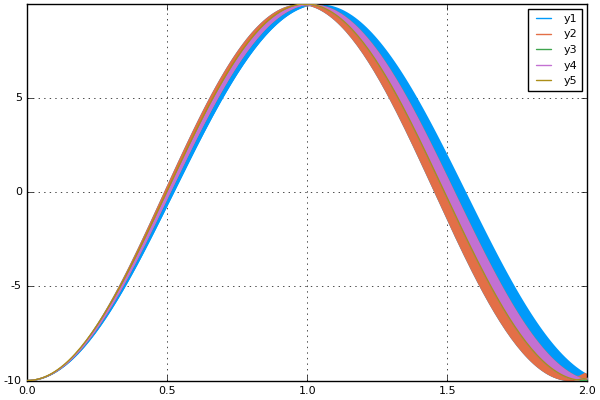

In [204]:
wpost = bayesposterior(m, [15], w)
plotquantiles(ts, sols, wpost)

In [209]:
function plotcol(w) 
    ts = 0:1/100:2
    sols = [GynC.Federn.odesol(k,ts) for k = xs]
    meas = [-4]
    
    pprior = plot(xs, w)
    
    pprioq = plotquantiles(ts, sols, w)
    ppostq = plotquantiles(ts, sols, bayesposterior(m, meas, w))
    [pprior, pprioq, ppostq]
end

wsplot = [wprior, ws["MPLE"][end], ws["NPMLE"][end], ws["DS-MLE"][end]]

allplots = hcat(map(plotcol, wsplot)...)'

4×3 Array{Plots.Plot{Plots.PyPlotBackend},2}:
 Plot{Plots.PyPlotBackend() n=1}  …  Plot{Plots.PyPlotBackend() n=5}
 Plot{Plots.PyPlotBackend() n=1}     Plot{Plots.PyPlotBackend() n=5}
 Plot{Plots.PyPlotBackend() n=1}     Plot{Plots.PyPlotBackend() n=5}
 Plot{Plots.PyPlotBackend() n=1}     Plot{Plots.PyPlotBackend() n=5}


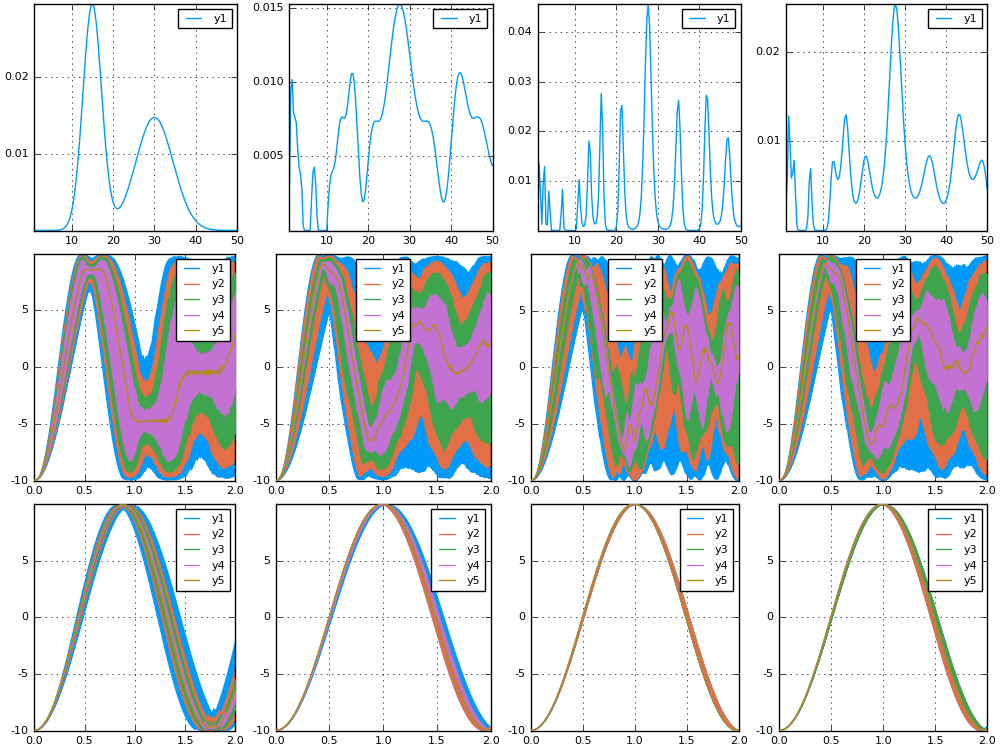

In [210]:
plot(allplots..., size=(1000, 750))


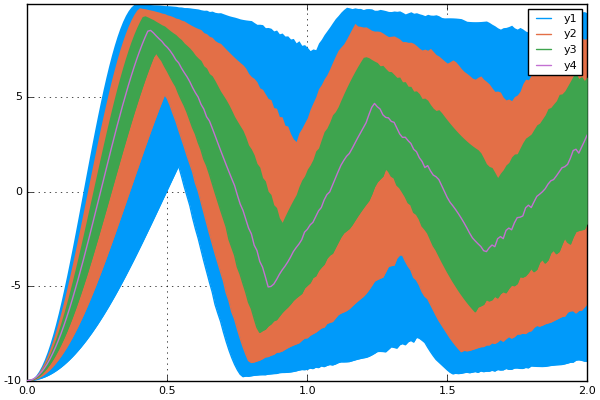

In [196]:
plotquantiles(ts, sols, w0)

In [ ]:
scatter!([1.0],)


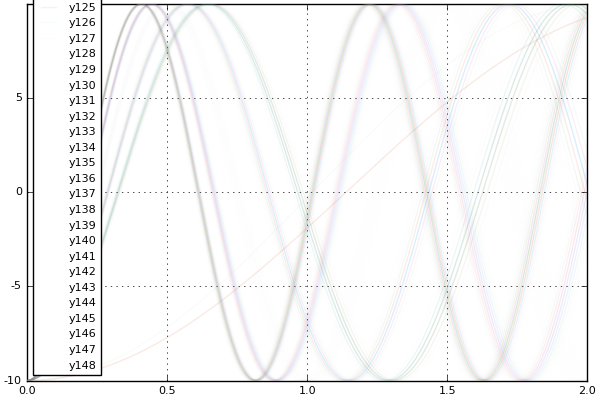

In [217]:
myw = bayesposterior(m, -4, wsplot[3])
plot(ts,hcat(sols...), alpha=myw'*3)


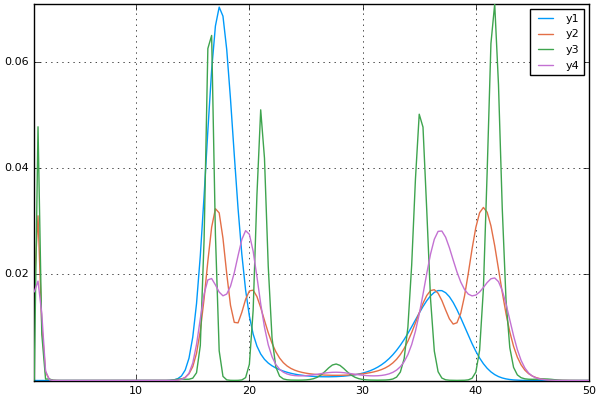

In [213]:
plot(xs,hcat(map(w->bayesposterior(m, -4, w), wsplot)...))